In [1]:
project_root = None

In [2]:
from pathlib import Path
import sys
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

if project_root is None:
    PROJECT_ROOT = Path.cwd().parent
else:
    PROJECT_ROOT = Path(project_root)
    
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src.data.cleaner import DataCleaner
from src.data.loader import DataLoader
from src.mining.clustering import EmployeeClustering
from src.mining.association import HRAssociationMining
from src.visualization.plots import plot_cluster_pca, plot_elbow

with open(PROJECT_ROOT / "configs" / "params.yaml") as f:
    cfg = yaml.safe_load(f)

DATA_PATH = PROJECT_ROOT / cfg["paths"]["raw_data"]
TARGET = cfg["target"]


In [3]:
FIG_DIR = PROJECT_ROOT / "outputs" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

sns.set(style="whitegrid")

In [4]:
df = DataLoader(DATA_PATH).load()
X, y, feature_names = DataCleaner().clean(df, target=TARGET)

processed_df = pd.DataFrame(X, columns=feature_names)

In [5]:
clusterer = EmployeeClustering(cfg["clustering"]["n_clusters"])
labels, sil = clusterer.fit(X)

print("Silhouette score:", sil)

Silhouette score: 0.1639317204611462


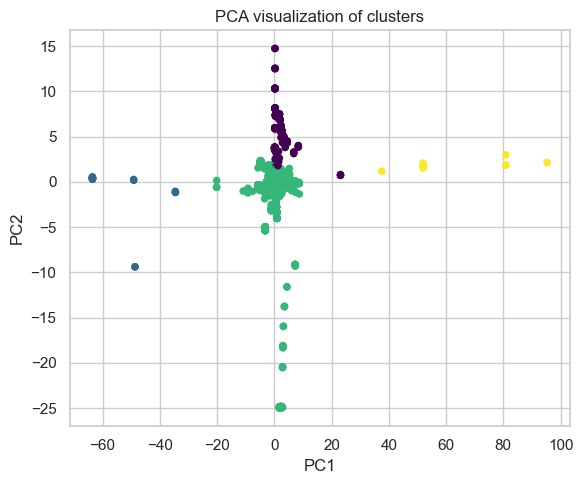

In [6]:
pca = PCA(n_components=2, random_state=cfg["seed"])
X_pca = pca.fit_transform(X)

plot_cluster_pca(
    X_pca,
    labels,
    save_path=FIG_DIR / "cluster_pca.png"
)

In [7]:
processed_df["Cluster"] = labels
processed_df["Attrition"] = y.values

profile = processed_df.groupby("Cluster").agg({
    "Age": "mean",
    "MonthlyIncome": "mean",
    "YearsAtCompany": "mean",
    "TotalWorkingYears": "mean",
    "DistanceFromHome": "mean",
    "JobLevel": "mean",
    "JobSatisfaction": "mean",
    "WorkLifeBalance": "mean",
    "EnvironmentSatisfaction": "mean",
    "Attrition": lambda x: (x == "Yes").mean(),
    "OverTime_Yes": "mean"
}).rename(columns={
    "Attrition": "AttritionRate",
    "OverTime_Yes": "OverTimeRate"
}).round(3)

profile


,Age,MonthlyIncome,YearsAtCompany,TotalWorkingYears,DistanceFromHome,JobLevel,JobSatisfaction,WorkLifeBalance,EnvironmentSatisfaction,AttritionRate,OverTimeRate
Cluster,,,,,,,,,,,
0,-0.033,0.247,0.822,0.300,0.017,0.248,0.038,0.072,-0.022,0.0,0.282
1,-0.320,-0.208,0.754,-0.014,0.168,0.112,0.190,-0.548,0.424,0.0,0.188
2,0.008,-0.040,-0.145,-0.052,-0.007,-0.045,-0.003,-0.002,0.004,0.0,0.283
3,0.204,0.025,-0.904,-0.014,0.291,0.143,-0.862,-0.450,-0.764,0.0,0.333


In [8]:
for cluster_id in profile.index:
    row = profile.loc[cluster_id]
    print(f"\nCluster {cluster_id}:")
    print(row)

    if row["AttritionRate"] > 0.3:
        print("→ Nhóm nguy cơ cao")
        print("Gợi ý: Tăng lương, giảm overtime, cải thiện work-life balance")

    elif row["MonthlyIncome"] > profile["MonthlyIncome"].median():
        print("→ Nhóm ổn định, thu nhập cao")
        print("Gợi ý: Giữ chính sách hiện tại, tập trung phát triển nghề nghiệp")

    else:
        print("→ Nhóm trung bình")
        print("Gợi ý: Theo dõi mức độ hài lòng và môi trường làm việc")


Cluster 0:
Age                       -0.033
MonthlyIncome              0.247
YearsAtCompany             0.822
TotalWorkingYears          0.300
DistanceFromHome           0.017
JobLevel                   0.248
JobSatisfaction            0.038
WorkLifeBalance            0.072
EnvironmentSatisfaction   -0.022
AttritionRate              0.000
OverTimeRate               0.282
Name: 0, dtype: float64
→ Nhóm ổn định, thu nhập cao
Gợi ý: Giữ chính sách hiện tại, tập trung phát triển nghề nghiệp

Cluster 1:
Age                       -0.320
MonthlyIncome             -0.208
YearsAtCompany             0.754
TotalWorkingYears         -0.014
DistanceFromHome           0.168
JobLevel                   0.112
JobSatisfaction            0.190
WorkLifeBalance           -0.548
EnvironmentSatisfaction    0.424
AttritionRate              0.000
OverTimeRate               0.188
Name: 1, dtype: float64
→ Nhóm trung bình
Gợi ý: Theo dõi mức độ hài lòng và môi trường làm việc

Cluster 2:
Age                    

In [9]:
assoc = HRAssociationMining(min_support=0.05, min_confidence=0.3)

df_assoc = assoc.preprocess(df)
rules = assoc.mine_rules(df_assoc)

rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
108,"(TenureLevel_ShortTenure, OverTime_Yes)",(Attrition_Yes),0.118243,0.160811,0.051351,0.434286,2.700600,1.0,0.032337,1.483415,0.714156,0.225519,0.325880,0.376807
109,(Attrition_Yes),"(TenureLevel_ShortTenure, OverTime_Yes)",0.160811,0.118243,0.051351,0.319328,2.700600,1.0,0.032337,1.295420,0.750381,0.225519,0.228050,0.376807
138,"(Attrition_Yes, TenureLevel_ShortTenure)",(IncomeLevel_LowIncome),0.095946,0.333108,0.066216,0.690141,2.071822,1.0,0.034256,2.152242,0.572237,0.182495,0.535368,0.444462
139,"(IncomeLevel_LowIncome, TenureLevel_ShortTenure)",(Attrition_Yes),0.209459,0.160811,0.066216,0.316129,1.965844,1.0,0.032533,1.227116,0.621490,0.217778,0.185081,0.363947
140,(Attrition_Yes),"(IncomeLevel_LowIncome, TenureLevel_ShortTenure)",0.160811,0.209459,0.066216,0.411765,1.965844,1.0,0.032533,1.343919,0.585461,0.217778,0.255907,0.363947
137,"(Attrition_Yes, IncomeLevel_LowIncome)",(TenureLevel_ShortTenure),0.086486,0.393919,0.066216,0.765625,1.943611,1.0,0.032148,2.585946,0.531458,0.159869,0.613294,0.466861
16,(Attrition_Yes),(OverTime_Yes),0.160811,0.282432,0.086486,0.537815,1.904226,1.0,0.041068,1.552555,0.565846,0.242424,0.355901,0.422018
17,(OverTime_Yes),(Attrition_Yes),0.282432,0.160811,0.086486,0.306220,1.904226,1.0,0.041068,1.209590,0.661753,0.242424,0.173274,0.422018
106,"(Attrition_Yes, TenureLevel_ShortTenure)",(OverTime_Yes),0.095946,0.282432,0.051351,0.535211,1.895006,1.0,0.024253,1.543857,0.522422,0.157025,0.352272,0.358515
183,"(IncomeLevel_HighIncome, OverTime_No)","(TenureLevel_LongTenure, Attrition_No)",0.239189,0.273649,0.118243,0.494350,1.806515,1.0,0.052789,1.436471,0.586805,0.299658,0.303850,0.463225


In [10]:
rules_attrition = rules[
    rules["consequents"].astype(str).str.contains("Attrition")
].copy()

rules_yes = rules_attrition[
    rules_attrition["consequents"].astype(str).str.contains("Attrition_Yes")
].sort_values("lift", ascending=False)

rules_no = rules_attrition[
    rules_attrition["consequents"].astype(str).str.contains("Attrition_No")
].sort_values("lift", ascending=False)

print("Top rules dẫn đến nghỉ việc:")
rules_yes.head(10)


Top rules dẫn đến nghỉ việc:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
108,"(TenureLevel_ShortTenure, OverTime_Yes)",(Attrition_Yes),0.118243,0.160811,0.051351,0.434286,2.700600,1.0,0.032337,1.483415,0.714156,0.225519,0.325880,0.376807
139,"(IncomeLevel_LowIncome, TenureLevel_ShortTenure)",(Attrition_Yes),0.209459,0.160811,0.066216,0.316129,1.965844,1.0,0.032533,1.227116,0.621490,0.217778,0.185081,0.363947
17,(OverTime_Yes),(Attrition_Yes),0.282432,0.160811,0.086486,0.306220,1.904226,1.0,0.041068,1.209590,0.661753,0.242424,0.173274,0.422018


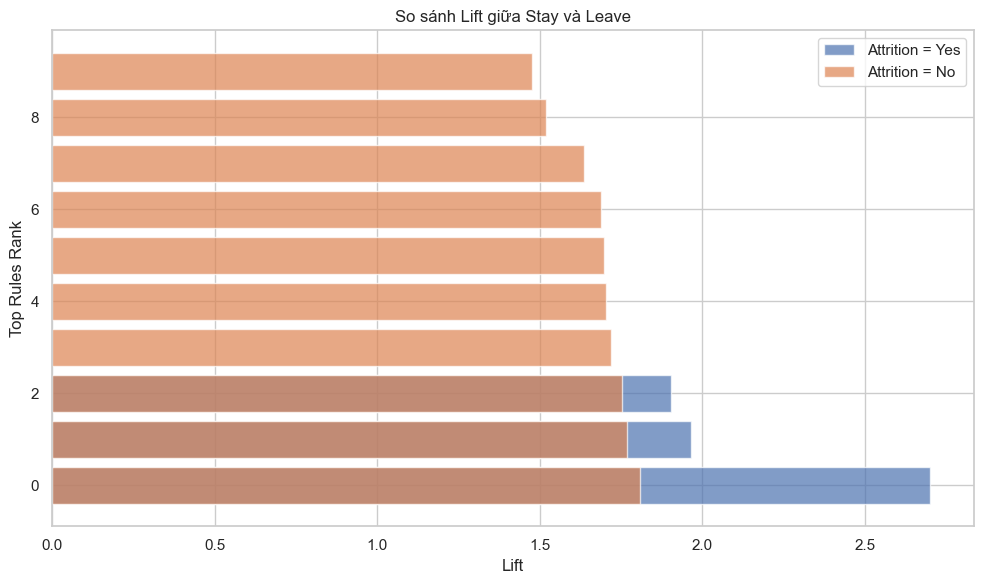

In [11]:
top_n = 10
top_yes = rules_yes.head(top_n)
top_no = rules_no.head(top_n)

plt.figure(figsize=(10, 6))

if len(top_yes) > 0:
    plt.barh(range(len(top_yes)), top_yes["lift"].values,
             alpha=0.7, label="Attrition = Yes")

if len(top_no) > 0:
    plt.barh(range(len(top_no)), top_no["lift"].values,
             alpha=0.7, label="Attrition = No")

plt.xlabel("Lift")
plt.ylabel("Top Rules Rank")
plt.title("So sánh Lift giữa Stay và Leave")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "association_lift_comparison.png")
plt.show()


In [12]:
print("=" * 60)
print("TOP LUẬT DẪN ĐẾN NGHỈ VIỆC")
print("=" * 60)

for i, (_, row) in enumerate(rules_yes.head(5).iterrows(), 1):
    print(f"\nLuật {i}:")
    print(f"Antecedents: {row['antecedents']}")
    print(f"Consequents: {row['consequents']}")
    print(f"Support: {row['support']:.3f}")
    print(f"Confidence: {row['confidence']:.3f}")
    print(f"Lift: {row['lift']:.3f}")


TOP LUẬT DẪN ĐẾN NGHỈ VIỆC

Luật 1:
Antecedents: frozenset({'TenureLevel_ShortTenure', 'OverTime_Yes'})
Consequents: frozenset({'Attrition_Yes'})
Support: 0.051
Confidence: 0.434
Lift: 2.701

Luật 2:
Antecedents: frozenset({'IncomeLevel_LowIncome', 'TenureLevel_ShortTenure'})
Consequents: frozenset({'Attrition_Yes'})
Support: 0.066
Confidence: 0.316
Lift: 1.966

Luật 3:
Antecedents: frozenset({'OverTime_Yes'})
Consequents: frozenset({'Attrition_Yes'})
Support: 0.086
Confidence: 0.306
Lift: 1.904


In [13]:
print("\n" + "=" * 60)
print("GỢI Ý CHÍNH SÁCH TỪ ASSOCIATION RULES")
print("=" * 60)

top_rules = rules_yes.head(3)

for i, (_, row) in enumerate(top_rules.iterrows(), 1):
    print(f"\nInsight {i}:")
    print(f"Điều kiện: {row['antecedents']}")
    print(f"→ Dẫn đến: {row['consequents']}")
    print(f"Lift: {row['lift']:.2f}")
    
    print("Gợi ý chính sách:")
    print("- Giảm overtime cho nhóm này.")
    print("- Tăng mức độ hài lòng công việc.")
    print("- Cải thiện cân bằng công việc – cuộc sống.")



GỢI Ý CHÍNH SÁCH TỪ ASSOCIATION RULES

Insight 1:
Điều kiện: frozenset({'TenureLevel_ShortTenure', 'OverTime_Yes'})
→ Dẫn đến: frozenset({'Attrition_Yes'})
Lift: 2.70
Gợi ý chính sách:
- Giảm overtime cho nhóm này.
- Tăng mức độ hài lòng công việc.
- Cải thiện cân bằng công việc – cuộc sống.

Insight 2:
Điều kiện: frozenset({'IncomeLevel_LowIncome', 'TenureLevel_ShortTenure'})
→ Dẫn đến: frozenset({'Attrition_Yes'})
Lift: 1.97
Gợi ý chính sách:
- Giảm overtime cho nhóm này.
- Tăng mức độ hài lòng công việc.
- Cải thiện cân bằng công việc – cuộc sống.

Insight 3:
Điều kiện: frozenset({'OverTime_Yes'})
→ Dẫn đến: frozenset({'Attrition_Yes'})
Lift: 1.90
Gợi ý chính sách:
- Giảm overtime cho nhóm này.
- Tăng mức độ hài lòng công việc.
- Cải thiện cân bằng công việc – cuộc sống.


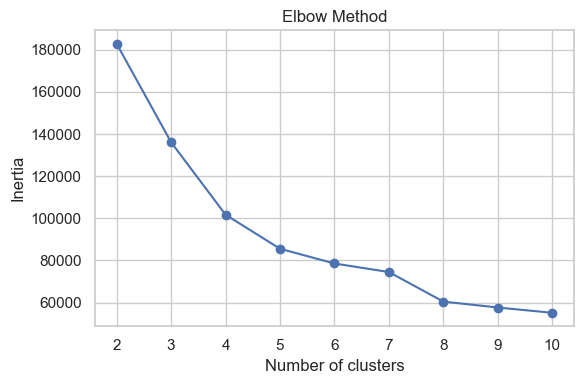

In [14]:

inertias = []
K = range(2, 11)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    inertias.append(km.inertia_)

plot_elbow(
    K,
    inertias,
    save_path=FIG_DIR / "clustering_elbow.png"
)


## Nhận xét và gợi ý chính sách

Từ các luật có lift cao dẫn đến Attrition = Yes:

1. Nhân viên OverTime + thu nhập thấp có xác suất nghỉ việc cao.
→ Đề xuất:
- Tăng lương nhóm thu nhập thấp
- Giảm thời gian làm thêm

2. Nhân viên có thâm niên dài + thu nhập cao thường ở lại.
→ Chính sách:
- Giữ ổn định phúc lợi
- Chương trình giữ chân nhân viên lâu năm
